# Crowding v2
This time dispersal follows a reversed logistic function and includes a homogenous fixed point for the heterotroph.

$ d_{H_{tot}} = d_{max} \cdot (\frac{1}{1 + exp(c \cdot (H^* - H_{tot}))}) $  
$ H_{tot,x} = H_{1,x} + H_{2,x} $  
$ H^* = ? $ 

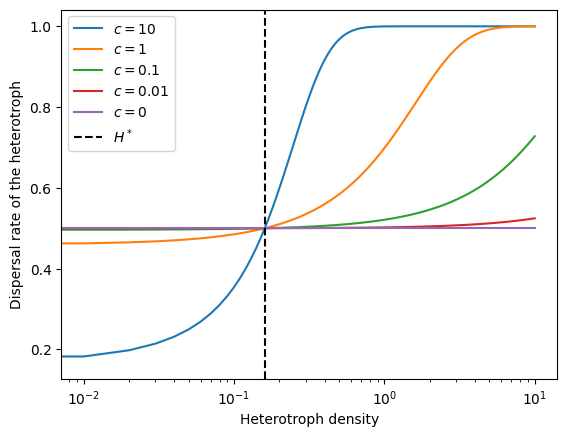

In [40]:
import numpy as np
from matplotlib import pyplot as plt

d_Hmax1 = 1
H_x_range = np.linspace(0, 10, 1000)
H_0 = 0.16

def dispersalrate(H_x):
    d_H1x = d_Hmax1 * ( 1 / (1 + np.exp(c * (H_0 - H_x))))
   # d_H1x = d_Hmax1 * ( 1 / (1 + np.exp(c * (H_x - x_01))))
    return (H_x, d_H1x)

c = 10
res10 = np.array([dispersalrate(a) for a in H_x_range])
plt.plot(res10[:,0],res10[:,1], label="$c = $" + str(c))
c = 1
res1 = np.array([dispersalrate(a) for a in H_x_range])
plt.plot(res1[:,0],res1[:,1], label="$c = $" + str(c))
c = 0.1
res01 = np.array([dispersalrate(a) for a in H_x_range])
plt.plot(res01[:,0],res01[:,1], label="$c = $" + str(c))
c = 0.01
res001 = np.array([dispersalrate(a) for a in H_x_range])
plt.plot(res001[:,0],res001[:,1], label="$c = $" + str(c))
c = 0
res0 = np.array([dispersalrate(a) for a in H_x_range])
plt.plot(res0[:,0],res0[:,1], label="$c = $" + str(c))

plt.axvline(x=H_0, color='black', linestyle='--', label="$H^*$")

#plt.yscale('log')
plt.xscale('log') 
#plt.yscale("log")
#plt.ylim(0,1)
# plt.xlim(10**-1,10**1)
plt.xlabel('Heterotroph density')
plt.ylabel('Dispersal rate of the heterotroph')
plt.legend()

## Packages

In [1]:
import numpy as np
from scipy import integrate as integ
from scipy import signal as signal
import sympy as sp
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets
from tqdm import tqdm
from turing_model import TuringModel as tm
from scipy.stats import linregress

## Model

In [41]:
def slow(var, t):
    # fill var
    N_a = var[0]
    N_b = var[1]
    A_a = var[2]
    A_b = var[3]
    H_1a = var[4]
    H_1b = var[5]
    H_2a = var[6]
    H_2b = var[7]
    d_H1a = var[8]
    d_H2a = var[9]
    d_H1b = var[10]
    d_H2b = var[11]

    # growth rate of autotrophs
    r_a = (r_max * N_a) / (N_h + N_a)
    r_b = (r_max * N_b) / (N_h + N_b)

    # growth rate of competitors
    g_1a = (a_1 * A_a) / (1 + a_1 * h * A_a)
    g_1b = (a_1 * A_b) / (1 + a_1 * h * A_b)
    g_2a = (a_2 * A_a) / (1 + a_2 * h * A_a)    
    g_2b = (a_2 * A_b) / (1 + a_2 * h * A_b)

    # # inflection points
    H_01 = 0.16
    H_02 = 0.16
    
    # dispersal rates of competitors
    d_H1a = d_Hmax1 * ( 1 / (1 + np.exp(c_1 * (H_01 - (H_1a+H_2a)))))
    d_H1b = d_Hmax1 * ( 1 / (1 + np.exp(c_1 * (H_01 - (H_1b+H_2b)))))
    d_H2a = d_Hmax2 * ( 1 / (1 + np.exp(c_2 * (H_02 - (H_1a+H_2a)))))
    d_H2b = d_Hmax2 * ( 1 / (1 + np.exp(c_2 * (H_02 - (H_1b+H_2b)))))
    
    # change of nutrients
    dN_a = D * (S - N_a) - r_a * A_a + d_N * (N_b - N_a)
    dN_b = D * (S - N_b) - r_b * A_b + d_N * (N_a - N_b)

    # change of autotrophs
    dA_a = r_a * A_a - ((g_1a * H_1a) + (g_2a * H_2a)) - D * A_a + d_A * (A_b - A_a)
    dA_b = r_b * A_b - ((g_1b * H_1b) + (g_2b * H_2b)) - D * A_b + d_A * (A_a - A_b)

    # change of competitors
    dH_1a = e * g_1a * H_1a - D * H_1a - d_H1a * H_1a + d_H1b * H_1b
    dH_1b = e * g_1b * H_1b - D * H_1b - d_H1b * H_1b + d_H1a * H_1a
    dH_2a = e * g_2a * H_2a - D * H_2a - d_H2a * H_2a + d_H2b * H_2b
    dH_2b = e * g_2b * H_2b - D * H_2b - d_H2b * H_2b + d_H2a * H_2a

    return(dN_a, dN_b, dA_a, dA_b, dH_1a, dH_1b, dH_2a, dH_2b, d_H1a, d_H2a, d_H1b, d_H2b)

In [27]:
# var
var = []

# set parameters
S = 4.8 # Nutrient supply concentration
D = 0.3 # Dilution rate
N_h = 1.5 # half saturation constant for nutrient uptake
r_max = 0.7 # growth rate of autotroph
h = 0.53 # handling time
e = 0.33 # conversion efficiency of competitor
d_N = 1 # Dispersal rate of nutrients 
d_A = 0.001 # dispersal rate of autotrophs

# competitiveness 
a_1 = 1 # attack rate of competitor 1 
a_2 = 1 # attack rate of competitor 2 

# adaptability
c_1 = 2 # dispersal adaptability of competitor 1 
c_2 = 2 # dispersal adaptability of competitor 2 
        # 0 = random dispersal, 2 = adaptive dispersal

# dispersal speed 
d_Hmax1 = 0.1 # maximal dispersal rates of competitor 1  
d_Hmax2 = 0.1 # maximal dispersal rates of competitor 2  

# time series
t_end = 10000
number_steps = 10000
t = np.linspace(0,t_end,number_steps)

# initials:[N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0]

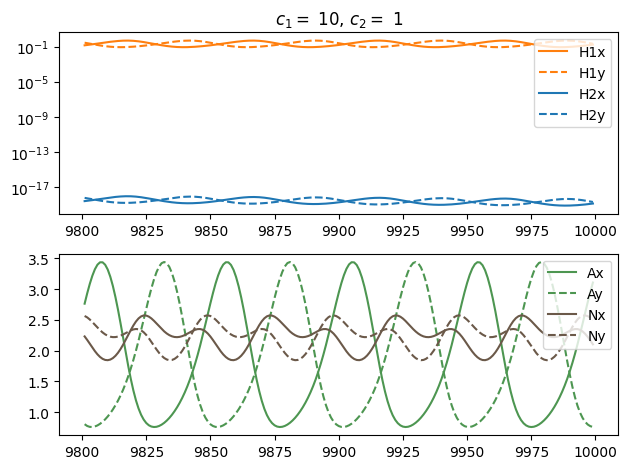

In [88]:
t_end = 10000
number_steps = 10000
t = np.linspace(0,t_end,number_steps)
c_1 = 10**1
c_2 = 10**0
d_Hmax1 = 10**-2
d_Hmax2 = 10**-2
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0.2, 0.3, 0, 0, 0, 0]
var = []
var = integ.odeint(slow, var0, t)
plt.subplot2grid((2,1),(0,0))
plt.plot(t[-200:-1], var[-200:-1, 4], "-", color="#FF7F0E", label="H1x")
plt.plot(t[-200:-1], var[-200:-1, 5], "--", color="#FF7F0E", label="H1y")
plt.plot(t[-200:-1], var[-200:-1, 6], "-", color="#1F77B4", label="H2x")
plt.plot(t[-200:-1], var[-200:-1, 7], "--", color="#1F77B4", label="H2y")
plt.yscale("log")
plt.legend(loc="upper right")
plt.title("$c_1 = $ " + str(c_1) + ", $c_2 = $ " + str(c_2))

plt.subplot2grid((2,1),(1,0))
plt.plot(t[-200:-1], var[-200:-1, 2], "-", color="#4D9651", label="Ax")
plt.plot(t[-200:-1], var[-200:-1, 3], "--", color="#4D9651", label="Ay")
plt.plot(t[-200:-1], var[-200:-1, 0], "-", color="#6B5949", label="Nx")
plt.plot(t[-200:-1], var[-200:-1:, 1], "--", color="#6B5949", label="Ny")
plt.legend(loc="upper right")
plt.tight_layout()

In [4]:
def find_extrema(x,n):
    """ returns an array with n extreme values of x"""
    
    min_index = signal.argrelmin(x)[0]         # create array with indices of local minima of x
    max_index = signal.argrelmax(x)[0]         # create array with indices of local maxima of x
    
    ext_index = np.append(min_index,max_index) # array with indices of local extrema in x
    ext_index = np.sort(ext_index)             # sort array (alternating minima and maxima)
    extrema = x[ext_index]                     # array with the actual values of the extrema
       
    if len(extrema) == 0:                      # if all values in x are the same and no extremum is found:
        extrema = np.append(extrema,x[-1])     #   return last value of x in this case
    while len(extrema) < n:                    # if less than n extrema have been found:
        extrema = np.append(extrema,extrema[0])#   repeat last extremum until array has n elements
    while len(extrema) > n:                    # if more than n extrema have been found:
        extrema = np.delete(extrema,-1)        #   delete elements until arrays has n elements
        
    return extrema

In [108]:
t_end = 100000
number_steps = 100000
t = np.linspace(0, t_end, number_steps)

# dispersal adaptability
c_1 = 0
c_2 = 5
d_Hmax1 = 10**0
d_Hmax2 = 10**0
c_range = np.geomspace(10**-4, 10**2, 50) #1000
d_Hmax_range = np.geomspace(10**-3, 10**-1, 50) #1000

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 10**-6, 10**-6, 0, 0, 0, 0]

num_extr = 12 # set number of maxima to be found

H1x_extr = []
H1y_extr = []
H2x_extr = []
H2y_extr = []

var = []

i = 0

for d_Hmax1 in tqdm(d_Hmax_range):
    var = integ.odeint(slow, var0, t)

    H1x_extr.append(find_extrema((var[-500:-1,4]),num_extr))
    H1y_extr.append(find_extrema((var[-500:-1,5]),num_extr))
    H2x_extr.append(find_extrema((var[-500:-1,6]),num_extr))
    H2y_extr.append(find_extrema((var[-500:-1,7]),num_extr))

    i += 1

# np.savetxt("./data/crowding/growthrate/H1Slope.csv", slopeH1, delimiter=",")
# np.savetxt("./data/crowding/growthrate/H2Slope.csv", slopeH2, delimiter=",")

100%|██████████| 50/50 [06:29<00:00,  7.80s/it]


Text(0.5, 1.0, '$c_{res} = $0, $c_{mut} = $5')

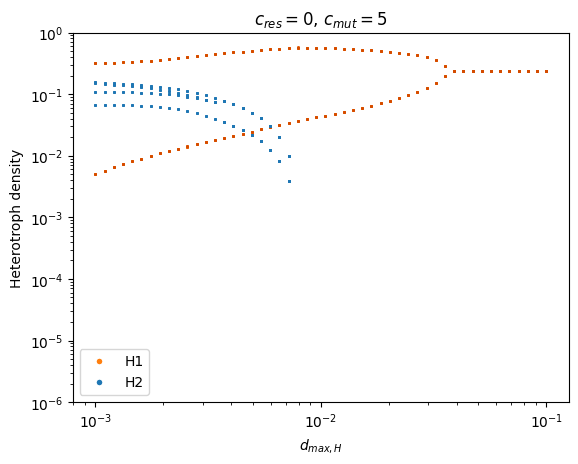

In [110]:
plt.plot(d_Hmax_range, H1x_extr[:], ".", markersize = 2, color="#FF7F0E")
plt.plot(d_Hmax_range, H1y_extr, ".", markersize = 2, color="#D44B00", alpha = 0.5)
plt.plot(d_Hmax_range, H2x_extr, ".", markersize = 2, color="#1F77B4")
plt.plot(d_Hmax_range, H2y_extr, ".", markersize = 2, color="#1F77B4", alpha = 0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$d_{max, H}$")
plt.ylabel("Heterotroph density")
plt.ylim(10**-6,10**0)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='H1', markerfacecolor='#FF7F0E', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='H2', markerfacecolor='#1F77B4', markersize=5)
]
plt.legend(handles=legend_elements, loc='lower left')
#plt.title("d_Hmax = " + str(d_Hmax1))
plt.title("$c_{res} = $" + str(c_1) + ", $c_{mut} = $" + str(c_2))

In [57]:
t_end = 20000
number_steps = 1000
t = np.linspace(0, t_end, number_steps)
d_Hmax2_range = np.geomspace(10**-4, 10**1, 25)
c_2_range = np.geomspace(10**-3, 10**2, 25)
# var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]
# since both competitors are exactly the same one can just be excluded since no changes are expected
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0, 0, 0, 0, 0, 0]

checkOsc_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))

var = []

i = 0
j = 0

for c_2 in tqdm(c_2_range):
    c_1 = c_2
    j = 0
    for d_Hmax2 in d_Hmax2_range:
        d_Hmax1 = d_Hmax2
        var = integ.odeint(slow, var0, t)

        # results[i,j] = ...

        density_H1x[i] = var[-1, 4]
        density_H1y[i] = var[-1, 5]
        density_H2x[i] = var[-1, 6]
        density_H2y[i] = var[-1, 7]

        checkOsc_H1x[i, j] = np.var(var[-200:-1, 4])
        checkOsc_H1y[i, j] = np.var(var[-200:-1, 5])
        checkOsc_H2x[i, j] = np.var(var[-200:-1, 6])
        checkOsc_H2y[i, j] = np.var(var[-200:-1, 7])

        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])
        meandensity_H1y[i, j] = np.mean(var[-200:-1, 5])
        meandensity_H2x[i, j] = np.mean(var[-200:-1, 6])
        meandensity_H2y[i, j] = np.mean(var[-200:-1, 7])

        j += 1
    i += 1

100%|██████████| 25/25 [11:02<00:00, 26.51s/it]


Text(0, 0.5, '$c$')

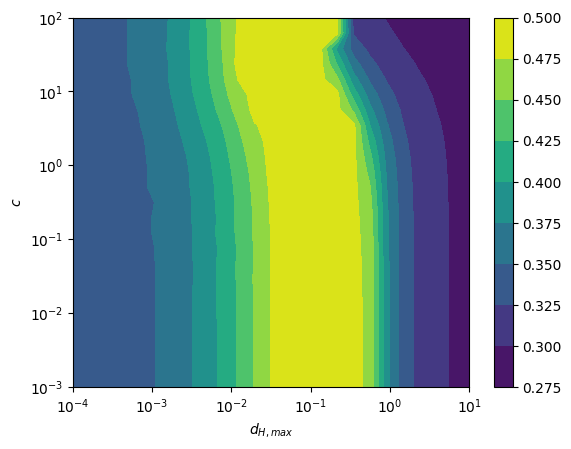

In [64]:
fig, ax = plt.subplots()
#im = plt.contourf((meandensity_H1x)-(meandensity_H1y)+checkOsc_H1x)
im = plt.contourf((meandensity_H1x)+(meandensity_H1y))
cbar = fig.colorbar(im)
ax.set_xticks(np.linspace(0, len(c_2_range)-1, 6))
ax.set_yticks(np.linspace(0, len(c_2_range)-1, 6))
ax.set_xticklabels(("$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$"), rotation=0)
ax.set_yticklabels(("$10^{-3}$", "$10^{-2}$", "$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"))
ax.set_xlabel('$d_{H,max}$')
ax.set_ylabel('$c$')
# k > 0.5
# dhmax > 10**-1